In [ ]:
import numpy as np 
import pandas as pd 
import os

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import *
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
from keras import backend as K

Using TensorFlow backend.


In [ ]:
!pip install -U -q kaggle --force

     |████████████████████████████████| 61kB 4.7MB/s 
     |████████████████████████████████| 122kB 24.0MB/s 
     |████████████████████████████████| 163kB 53.4MB/s 
     |████████████████████████████████| 235kB 67.8MB/s 
     |████████████████████████████████| 61kB 10.0MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 143kB 64.3MB/s 
     |████████████████████████████████| 81kB 12.4MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.23.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.14.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [ ]:
from google.colab import files
f=files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
#!kaggle competitions download -c nnfl-cnn-lab2
#!kaggle competitions download -c nnfl-lab-3-nlp
!kaggle competitions download -c nnfl-lab-4

  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 103MB/s]


In [ ]:
%%bash
cd /content
unzip nnfl-lab-4.zip

Archive:  nnfl-lab-4.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
data = pd.read_csv('/content/train.csv')
pd.set_option('display.max_colwidth',-1)
data.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,ID,Sentence1,Sentence2,Class
0,0,"But instead of returning to heaven , Annie decided to join Chris in hell forever .","But instead of returning to Heaven , Chris chooses to join Annie forever in Hell .",0
1,1,"In 2016 , Bacardi announced new branding and plans to sell their version of Havana Club nationally , which will be burned in Florida and bottled in Puerto Rico .","In 2016 , Bacardi announced new branding and plans to sell their version of Havana Club nationally , which will be distilled in Puerto Rico and bottled in Florida .",0
2,2,"Kweku Baako Jnr had four children . One of them , Baako is a journalist and editor of the `` New Crusading Guide '' newspaper .","Baako had four children , one of whom was Kweku Baako Jnr , a journalist and editor of the newspaper `` New Crusading Guide '' .",0
3,3,"As with the Navy , the Army has a single-track system , where officers from other Navy communities transfer over to Foreign Area Officer permanently .","Like the army , the Navy has a single-track system , where officers from other Navy communities permanently transfer to Foreign Area Officer .",0
4,4,Sissi units have fewer crew served weapons and more sniper rifles than regular infantry .,Sissi units have more weapons served by the crew and fewer sniper rifles than regular infantry .,0
5,5,"However , the United States later forced other nations and American companies to restrict trade with Cuba with foreign subsidiaries .","However , the United States later pressured other nations and foreign companies with American subsidiaries to restrict trade with Cuba .",0
6,6,Deutsche Bahn opened a new underground tunnel to the new railway station Filderstadt on 29 September 2001 .,"On 29 September 2001 , Deutsche Bahn opened a new tunnel to the new Filderstadt U-Bahn ( underground ) station .",0
7,7,"Some Hebrew and Aramaic abbreviations may not be included here ; more may be found in the List of Hebrew abbreviations and the List of Aramaic abbreviations , respectively .","Some Hebrew and Aramaic abbreviations may not be included here , and others may be found in the list of Hebrew abbreviations or in the list of Aramaic abbreviations .",1
8,8,`` Yesteryear '' is the first episode of the second season of animated American science - fiction - television series .,`` Yesteryear '' is the second episode of the first season of the animated American Science - Fiction - TV series .,0
9,9,Principal photography took place in additional installments between July 2016 and October 2016 with small pick-up days in December 2016 and January 2017 .,Principal - Photography took place between July 2016 and October 2016 in small installments with additional collection dates in December 2016 and January 2017 .,0


In [ ]:
data_test = pd.read_csv('/content/test.csv')
pd.set_option('display.max_colwidth',-1)
data_test.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,ID,Sentence1,Sentence2
0,16000,How do I increase the rank on my website in SEO?,What are some tips on how to increase rank in search engines?
1,16001,I'm a boy. I masturbate. I'm 13. Is it bad to masturbate?,Why do I masturbate when I'm stressed?
2,16002,"The fourth season was premiered on 7 June 2010 , and like the third season was the system of competition for mixed couples .","The third season was premiered on June 7 , 2010 . Like the fourth season the system of the competition was in mixed couples ."
3,16003,"In 2003 , he moved to London and lived there for sixteen months before returning to South Africa in September 2004 .",He moved to South Africa in 2003 and lived there 16 months before returning to London in September 2004 .
4,16004,"Shawn told Shawn that his mother was not dead and his father was still married and on the day of the wedding of Colleen and Santo , Shawn told Colleen .","Stefano told Shawn that his mother was not dead and his father was still married and on the day of Colleen and Santo 's wedding , Shawn told Colleen ."
5,16005,She was the sister of William who was already married to David King Udall 's sister Eliza Stewart .,"She was the sister of William , who had already been married to David King Udall 's sister Eliza Stewart ."
6,16006,The river Amaradia is a tributary of the River Grui in Romania .,The Grui River is a tributary of the River Amaradia in Romania .
7,16007,"In 2009 , Damien Ritter founded his own Funk Volume record label with Hopsin .","In 2009 , Hopsin founded his independent record label Funk Volume with Damien Ritter ."
8,16008,He also gained popularity by replacing Archie Kao with Adam Rodriguez .,He also gained popularity by replacing Adam Rodriguez with `` and Archie Kao on '' .
9,16009,"Darrell Fetty first married Carolyne McCoy , who is a descendant of the famous feud families ( her mother was a Hatfield , her father was a McCoy ) .","Darrell Fetty first married Carolyne McCoy , who is a descendant of the famous feuding families ( her mother was a Hatfield , her father a McCoy ) ."


In [ ]:
!wget https://github.com/kmr0877/IMDB-Sentiment-Classification-CBOW-Model/raw/master/glove.6B.50d.txt.gz

--2020-04-28 11:18:06--  https://github.com/kmr0877/IMDB-Sentiment-Classification-CBOW-Model/raw/master/glove.6B.50d.txt.gz
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kmr0877/IMDB-Sentiment-Classification-CBOW-Model/master/glove.6B.50d.txt.gz [following]
--2020-04-28 11:18:07--  https://raw.githubusercontent.com/kmr0877/IMDB-Sentiment-Classification-CBOW-Model/master/glove.6B.50d.txt.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69182520 (66M) [application/octet-stream]
Saving to: ‘glove.6B.50d.txt.gz’

glove.6B.50d.txt.gz 100%[===================>]  65.98M   298MB/s    in 0.2s    

2020-04

In [ ]:
! gunzip glove.6B.50d.txt.gz

In [ ]:
num_words = 30000
tokenizer = Tokenizer(num_words=num_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                   lower=True,split=' ')
data["Sentence1"]=data["Sentence1"].str.lower() 
data["Sentence2"]=data["Sentence2"].str.lower() 
data_test["Sentence1"]=data_test["Sentence1"].str.lower() 
data_test["Sentence2"]=data_test["Sentence2"].str.lower() 

print(data['Sentence1'][0])
print(data['Sentence2'][0])
print(data_test['Sentence1'][0])
print(data_test['Sentence2'][0])
tokenizer.fit_on_texts(data['Sentence1'].values+data['Sentence2'].values)
#tokenizer.fit_on_texts(data_test['tweet'].values)
X1 = tokenizer.texts_to_sequences(data['Sentence1'].values)
X2 = tokenizer.texts_to_sequences(data['Sentence2'].values)
X1_test = tokenizer.texts_to_sequences(data_test['Sentence1'].values)
X2_test = tokenizer.texts_to_sequences(data_test['Sentence2'].values)
#X_test = tokenizer.texts_to_sequences(data_test['tweet'].values)
print(X1[0])
print(X2[0])
print(X1_test[0])
print(X2_test[0])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

max_length_of_text = 100
X1 = pad_sequences(X1, maxlen=max_length_of_text)
X2 = pad_sequences(X2, maxlen=max_length_of_text)
X1_test = pad_sequences(X1_test, maxlen=max_length_of_text)
X2_test = pad_sequences(X2_test, maxlen=max_length_of_text)
#X_Test = pad_sequences(X_test, maxlen=max_length_of_text)
print(word_index)
print("Padded Sequences: ")
print(X1)
print(X1[0])
print(X2)
print(X2[0])
y = data['Class']

In [ ]:
embeddings_index = {}
f = open('glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors in pretrained word vector model.' % len(embeddings_index))
print('Dimensions of the vector space : ', len(embeddings_index['the']))
print('the vector space : ', embeddings_index['the'])

Found 400000 word vectors in pretrained word vector model.
Dimensions of the vector space :  50
the vector space :  [ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
 -1.1514e-01 -7.8581e-01]


In [ ]:
EMBEDDING_DIM = 50
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
#from keras.layers import Embedding

#embedding_layer = Embedding(len(word_index) + 1,
#                            EMBEDDING_DIM,
#                            weights=[embedding_matrix],
#                            input_length=max_length_of_text,
#                            trainable=True)

In [ ]:
# import numpy
# from keras.datasets import imdb
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
# from keras.layers.embeddings import Embedding
# from keras.preprocessing import sequence
# # fix random seed for reproducibility
# #numpy.random.seed(7)
# # load the dataset but only keep the top n words, zero the rest
# #top_words = 5000
# #(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
# # truncate and pad input sequences
# #max_review_length = 500
# #X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
# #X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
# # create the model
# #embedding_vecor_length = 32
# model = Sequential()
# model.add(embedding_layer = Embedding(len(word_index) + 1,
#                             EMBEDDING_DIM,
#                             weights=[embedding_matrix],
#                             input_length=max_length_of_text,
#                             trainable=True))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(LSTM(256,dropout=0.5, recurrent_dropout=0.5))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())
# model.fit(X_train, y_train, epochs=3, batch_size=64)
# # Final evaluation of the model
# scores = model.evaluate(X_test, y_test, verbose=0)
# print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
# from keras.layers import Conv1D,MaxPooling1D,Flatten,GlobalAveragePooling1D,BatchNormalization,Dropout
# from keras.layers import concatenate,Lambda
# from keras import backend as K
# lstm_out=128
# def model_conv1D_(emb_matrix):
    
#     # The embedding layer containing the word vectors
#     emb_layer = Embedding(
#         input_dim=emb_matrix.shape[0],
#         output_dim=emb_matrix.shape[1],
#         weights=[emb_matrix],
#         input_length=max_length_of_text,
#         trainable=True
#     )
#     # Define inputs
#     seq1 = Input(shape=(200,))
#     seq2 = Input(shape=(200,))

#     # Run inputs through embedding
#     emb1 = emb_layer(seq1)
#     emb2 = emb_layer(seq2)

#     mergea = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(emb1)
#     mergea = MaxPooling1D(pool_size=2)(mergea)
#     mergea = Dropout(0.5)(mergea)
#     mergea = LSTM(256, dropout=0.5, recurrent_dropout=0.5, return_sequences=False)(mergea)
#     mergeb = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(emb2)
#     mergeb = MaxPooling1D(pool_size=2)(mergeb)
#     mergeb = Dropout(0.5)(mergeb)
#     mergeb = LSTM(256, dropout=0.5, recurrent_dropout=0.5, return_sequences=False)(mergeb)
    
#     # We take the explicit absolute difference between the two sentences
#     # Furthermore we take the multiple of different entries to get a different measure of equalness
#     diff = Lambda(lambda x: K.abs(x[0] - x[1]), output_shape=(256,))([mergea, mergeb])
#     mul = Lambda(lambda x: x[0] * x[1], output_shape=(256,))([mergea, mergeb])
 
#     merge = concatenate([diff, mul])
    
#     # The MLP that determines the outcome
#     x = Dropout(0.5)(merge)
#     x = BatchNormalization()(x)
#     x = Dense(1024, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     x = Dense(256, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     x = BatchNormalization()(x)
#     pred = Dense(1, activation='sigmoid')(x)
#     model = Model(inputs=[seq1, seq2], outputs=pred)#, magic_input, distance_input], outputs=pred)
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

#     return model

In [ ]:
# from keras.layers import Conv1D,MaxPooling1D,Flatten,GlobalAveragePooling1D,BatchNormalization,Dropout
# from keras.layers import concatenate,Lambda
# from keras import backend as K
# from keras.regularizers import l2

# lstm_out=128
# def model_conv1D_(emb_matrix):
#     emb_layer = Embedding(
#         input_dim=emb_matrix.shape[0],
#         output_dim=emb_matrix.shape[1],
#         weights=[emb_matrix],
#         input_length=max_length_of_text,
#         trainable=True
#     )
    
    
#     seq1 = Input(shape=(200,))
#     seq2 = Input(shape=(200,))

    
#     emb1 = emb_layer(seq1)
#     emb2 = emb_layer(seq2)

    

#     conv1a = conv1(emb1)
#     glob1a = GlobalAveragePooling1D()(conv1a)
    
#     conv1b = conv1(emb2)
#     glob1b = GlobalAveragePooling1D()(conv1b)
    

#     conv2a = conv2(emb1)
#     glob2a = GlobalAveragePooling1D()(conv2a)
    
#     conv2b = conv2(emb2)
#     glob2b = GlobalAveragePooling1D()(conv2b)
    

#     conv3a = conv3(emb1)
#     glob3a = GlobalAveragePooling1D()(conv3a)
    
#     conv3b = conv3(emb2)
#     glob3b = GlobalAveragePooling1D()(conv3b)
    

#     conv4a = conv4(emb1)
#     glob4a = GlobalAveragePooling1D()(conv4a)
    
#     conv4b = conv4(emb2)
#     glob4b = GlobalAveragePooling1D()(conv4b)
    

#     conv5a = conv5(emb1)
#     glob5a = GlobalAveragePooling1D()(conv5a)
    
#     conv5b = conv5(emb2)
#     glob5b = GlobalAveragePooling1D()(conv5b)

#     mergea = concatenate([glob1a, glob2a, glob3a, glob4a, glob5a])
#     mergeb = concatenate([glob1b, glob2b, glob3b, glob4b, glob5b])

    
    
#     diff = Lambda(lambda x: K.abs(x[0] - x[1]), output_shape=(2 * 256 + 2*64 +2*512,))([mergea, mergeb])
#     mul = Lambda(lambda x: x[0] * x[1], output_shape=(2 * 256 + 2*64 +2*512,))([mergea, mergeb])
    
#     merge = concatenate([diff, mul])

    
#     x = Dropout(0.5)(merge)
#     x = BatchNormalization()(x)
    
#     x = Dense(1024, activation='relu')(x)
#     x = Dropout(0.2)(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(0.2)(x)
#     x = BatchNormalization()(x)
#     pred = Dense(1, activation='sigmoid')(x)

#     model = Model(inputs=[seq1, seq2], outputs=pred)
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

#     return model

In [ ]:
# model=model_conv1D_(embedding_matrix)

In [ ]:
def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

In [ ]:
# The visible layer
left_input = Input(shape=(max_length_of_text,), dtype='int32')
right_input = Input(shape=(max_length_of_text,), dtype='int32')

embedding_layer = Embedding(len(embedding_matrix),50, weights=[embedding_matrix], input_length=max_length_of_text,trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(50)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])
print(malstm_distance.shape)
# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

(None, 1)


In [ ]:
malstm.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 50)      1503650     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 64)           29440       embedding_1[0][0]          

In [ ]:
from keras.optimizers import Adadelta , Adam
optimizer = Adam(lr = 0.1)

malstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# earlystop = EarlyStopping(monitor = 'val_acc', patience=4)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3 , verbose=1, factor=0.6, min_lr=0.00001)
mc = ModelCheckpoint('/content/drive/My Drive/NNFL/NLP/Lab4/day5_model_personalID_3.h5', monitor = 'val_loss', verbose = 1, save_best_only = True, save_weights_only = True)

In [ ]:
malstm.load_weights('/content/drive/My Drive/NNFL/NLP/Lab4/day5_model_personalID_3.h5')
epochs=30
history=malstm.fit(
x=[X1, X2],
y=y, batch_size=64,
epochs=epochs,
verbose=1,
# callbacks=[checkpoint],
validation_split=0.1, shuffle=True, 
class_weight={0: 0.5333, 1: 0.4472},
callbacks=[mc,learning_rate_reduction],
)

Train on 14400 samples, validate on 1600 samples
Epoch 1/30
14400/14400 [==============================] - 69s 5ms/step - loss: 0.0648 - acc: 0.8193 - val_loss: 0.0879 - val_acc: 0.7281

Epoch 00001: val_loss improved from inf to 0.08788, saving model to /content/drive/My Drive/NNFL/NLP/Lab4/day5_model_personalID_3.h5
Epoch 2/30
14400/14400 [==============================] - 69s 5ms/step - loss: 0.0640 - acc: 0.8223 - val_loss: 0.0879 - val_acc: 0.7256

Epoch 00002: val_loss did not improve from 0.08788
Epoch 3/30
14400/14400 [==============================] - 67s 5ms/step - loss: 0.0634 - acc: 0.8256 - val_loss: 0.0886 - val_acc: 0.7163

Epoch 00003: val_loss did not improve from 0.08788
Epoch 4/30
14400/14400 [==============================] - 68s 5ms/step - loss: 0.0631 - acc: 0.8245 - val_loss: 0.0885 - val_acc: 0.7231

Epoch 00004: val_loss did not improve from 0.08788

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
Epoch 5/30
14400/14400 [========

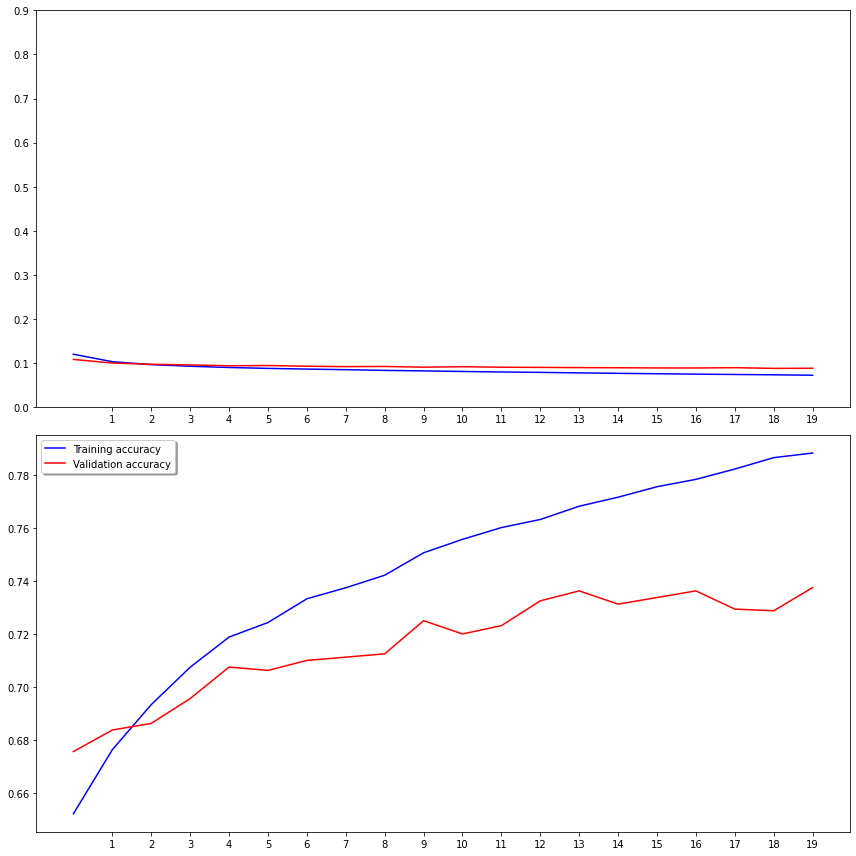

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
from urllib.request import urlopen,urlretrieve
from PIL import Image
from tqdm import tqdm_notebook
%matplotlib inline
from sklearn.utils import shuffle
import cv2

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
y_test = malstm.predict([X1_test,X2_test], batch_size = 128)

In [ ]:
import sys
import numpy
numpy.set_printoptions(threshold=1000)
print(y_test)

[[0.06403356]
 [0.40806824]
 [0.5946079 ]
 ...
 [0.35154   ]
 [0.2578276 ]
 [0.3721447 ]]


In [ ]:
for i in range(y_test.shape[0]):
  if y_test[i]>0.5:
    y_test[i]=1
  else:
    y_test[i]=0

In [ ]:
import sys
import numpy
numpy.set_printoptions(threshold=1000)
print(y_test.astype(int))

[[0]
 [0]
 [1]
 ...
 [0]
 [0]
 [0]]


In [ ]:
print(sum(y_test==1))
print(sum(y_test==0))

[1755]
[2945]


In [ ]:
del data_test['Sentence1']
del data_test['Sentence2']

In [ ]:
data_test['Class']=y_test.astype(int)

In [ ]:
print(data_test)

         ID  Class
0     16000  0    
1     16001  0    
2     16002  1    
3     16003  0    
4     16004  1    
...     ... ..    
4695  20695  0    
4696  20696  1    
4697  20697  0    
4698  20698  0    
4699  20699  0    

[4700 rows x 2 columns]


In [ ]:
data_test.to_csv("/content/drive/My Drive/NNFL/NLP/Lab4/day5_model_campusID_1.csv",index = False)

In [ ]:
malstm.save_weights("/content/drive/My Drive/NNFL/NLP/Lab4/day5_model_campusID_1.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!kaggle competitions submit -c nnfl-lab-4 -f /content/drive/My\ Drive/NNFL/NLP/Lab4/day5_model_campusID_1.csv -m "Lab4/day5_model_campusID_1.h5"

100% 36.7k/36.7k [00:04<00:00, 9.13kB/s]
Successfully submitted to NNFL Lab-4